In [1]:
# Environment Setup
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
sp.init_printing()

# Move Kinematics

Every move has a target "entry" and "exit" velocity that we must keep when entering or exiting the move. Within this move, the velocity can be anything. It makes sense to maximize the time spent cruising at a target upper bound on velocity, which we call the "cruise velocity." Spending the most time here means our overall series of paths that we're trying to execute are executing as quickly as possible while respecting the physical acceleration limits we apply to the machine.

## General Case
To follow a trapezoidal velocity profile, we actually have 3 move regions.

When accelerating, we follow
$$
x_a(t) = x_0 + v_0t + \frac{1}{2}at^2
$$
When cruising, we follow:
$$
x_c(t) = x_0 + v_0t
$$
When decelerating, our starting position is now wherever we finished off after cruising, our starting velocity is our cruise velocity, and our starting $a$ flips from positive to negative from our accelerating equation. If $a$ is a constant, we get:
$$
x_d(t) = x_{cf} + v_ct - \frac{1}{2}at^2
$$



## "Short Move" Case
Some moves are so short, the machine carriage never has enough time to get to the cruise velocity. In that case, we just do our best. Since we'll be planning two regions, we need to know when (or equivalently at what position) they intersect.

The cell below solves for the max velocity when we never have a cruise region.

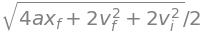

In [2]:
t_i, t_m, t_f, v_i, v_m, v_f, v_c, x_f, t, a = sp.symbols('t_i, t_m, t_f, v_i, v_m, v_f, v_c, x_f, t, a')

x_f_fn = v_i*t_m + sp.Rational(1,2)*a*t_m**2 + v_m*(t_f - t_m) - sp.Rational(1,2)*a*(t_f - t_m)**2 - x_f
v_max_fn = v_i + a*t_m - v_m
v_f_fn = v_m - a*(t_f-t_m) - v_f

# We get two solutions. For positive a, v_i, and v_f (which will always be true), we want the first solution
solns = sp.solve([x_f_fn, v_max_fn, v_f_fn], t_f, v_m, t_m)

t_final, v_max, t_max = solns[0]
givens = {v_f: 1,
          v_i: 1,
          x_f: 1,
          a: 10}
#display(t_final.subs(givens).evalf())
#display(v_max.subs(givens).evalf())
#display(t_max.subs(givens).evalf())

display(v_max)

## X inverses
The above kinematics equations give us x as a function of time. But since stepper motors can only move in discrete position steps, we actually want time as a function of the next possible position. That means we need the inverse function for all three regions.

The cruise region is easy since acceleration is zero and our equation is a line.

In [3]:
x, x_i, v_cruise, t = sp.symbols('x, x_i, v_c, t')
sp.solve(x_i + v_cruise*t - x, t)

The regions where we're accelerating/decelerating have two solutions, but only one is valid (where $t \ge 0$).

For the accelerating region, we get:

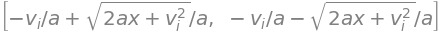

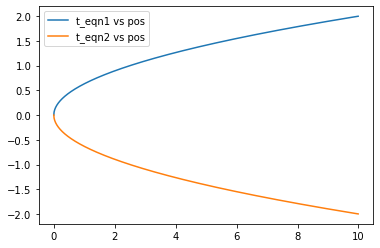

In [31]:
x, x_i, v_i = sp.symbols('x, x_i, v_i')
a = sp.symbols('a', positive=True)
v_cruise = sp.symbols('v_c', positive=True)
t = sp.symbols('t', positive=True, real=True)

givens = {x_i: 0}
t_eqns = list(sp.solveset((x_i + v_i*t + sp.Rational(1,2)*a*t**2 - x).subs(givens), t))
display(t_eqns)

givens = {a: 5,
          v_i: 0,
          v_cruise: 10,
          x_i: 0}
#t_eqns = list()
t_eqn1 = sp.lambdify(x, t_eqns[0].subs(givens))
t_eqn2 = sp.lambdify(x, t_eqns[1].subs(givens))

pos_series = np.arange(0, 10, 0.01)
t_eqn1_series = [t_eqn1(x) for x in pos_series]
t_eqn2_series = [t_eqn2(x) for x in pos_series]

plt.plot(pos_series, t_eqn1_series, label = "t_eqn1 vs pos")
plt.plot(pos_series, t_eqn2_series, label="t_eqn2 vs pos")
plt.legend()
plt.show()

Here, we can see that we want to take the first eqn, where $t$ is strictly positive.


For the decelerating region, we get:

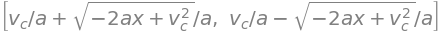

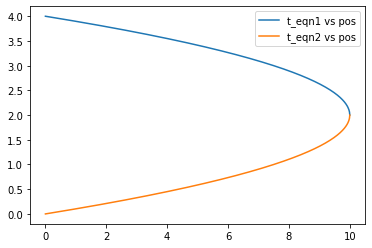

In [34]:
givens = {x_i: 0}
t_eqns = list(sp.solveset((x_i + v_cruise*t - sp.Rational(1,2)*a*t**2 - x).subs(givens), t))
display(t_eqns)

givens = {a: 5, # minus sign is in the eqn.
          v_i: 0,
          v_cruise: 10,
          x_i: 0}
t_eqn1 = sp.lambdify(x, t_eqns[0].subs(givens))
t_eqn2 = sp.lambdify(x, t_eqns[1].subs(givens))

pos_series = np.arange(0, 10.01, 0.01)
t_eqn1_series = [t_eqn1(x) for x in pos_series]
t_eqn2_series = [t_eqn2(x) for x in pos_series]

plt.plot(pos_series, t_eqn1_series, label = "t_eqn1 vs pos")
plt.plot(pos_series, t_eqn2_series, label="t_eqn2 vs pos")
plt.legend()
plt.show()

Here we want to take the second equation, which is defined from $t=0$ to $t=2$.